# 04 — PyTorch Basics
*From tensors and autograd to training your first MLP — the essentials for deep RL.*

**What you'll learn**
- `torch.Tensor` and **autograd** (automatic differentiation)
- Building models with `nn.Module` / `nn.Sequential`
- Losses, optimizers (SGD, Adam), and training loops
- Classification & regression mini‑examples
- Plotting learning curves

> Policies and value functions in deep RL are just neural networks trained with these fundamentals (e.g., PPO actor & critic).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## 1. Autograd in a Nutshell

PyTorch’s **autograd** system automatically computes derivatives of tensor operations using **reverse-mode differentiation**, the same principle behind backpropagation.

When a tensor is created with  
```python
x = torch.tensor([...], requires_grad=True)
```

PyTorch records all operations on it in a **computation graph**. When you call `.backward()`, it traverses this graph in reverse to compute gradients efficiently.


### Mathematical Intuition

For a scalar function
$$
y = f(x_1, x_2, \dots, x_n),
$$
autograd computes
$$
\frac{\partial y}{\partial x_i}
$$
for each parameter via the **chain rule**:

$$
\frac{\partial y}{\partial x_i} = \sum_j \frac{\partial y}{\partial z_j} \frac{\partial z_j}{\partial x_i}.
$$

In vector form, this becomes efficient **reverse-mode differentiation**, ideal when the number of outputs ≪ number of parameters — exactly the case in neural networks.


### RL Connection

- Policy networks, value functions, and Q-networks all rely on autograd for computing
  $$
  \nabla_\theta J(\pi_\theta) = \mathbb{E}*\pi [\nabla*\theta \log \pi_\theta(a|s) , G_t].
  $$
- Autograd automates gradient computation for loss functions like:
  - Policy gradient loss
  - Temporal-difference (TD) error
  - Actor-critic combined objectives
- This makes it easy to **experiment and debug** custom RL algorithms without manual gradient derivations.

In [3]:
# Define tensors with gradient tracking enabled
x = torch.tensor([2.0, -1.0], requires_grad=True)
w = torch.tensor([1.5, -3.0], requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

# Forward pass: simple linear model y = w·x + b
y = torch.dot(w, x) + b

# Backward pass: compute gradients dy/dx, dy/dw, dy/db
y.backward()

print(f"Output y: {y.item():.3f}")
print("dy/dx:", x.grad)
print("dy/dw:", w.grad)
print("dy/db:", b.grad)

Output y: 6.500
dy/dx: tensor([ 1.5000, -3.0000])
dy/dw: tensor([ 2., -1.])
dy/db: tensor(1.)


## 2. A Tiny MLP for Classification

A **Multi-Layer Perceptron (MLP)** is a feedforward neural network composed of linear layers and nonlinear activations. It learns a function $ f_\theta: \mathbb{R}^n \to \mathbb{R}^k $ by minimizing a loss (e.g., cross-entropy for classification).


### Structure
For an input $x \in \mathbb{R}^n$:
$$
h_1 = \sigma(W_1 x + b_1), \quad
\hat{y} = \text{softmax}(W_2 h_1 + b_2)
$$
where:
- $W_i, b_i$ are learnable parameters,  
- $\sigma(\cdot)$ is a nonlinear activation (e.g., ReLU, tanh),  
- The **softmax** maps logits to class probabilities.

The model learns by minimizing:
$$
\mathcal{L}(\theta) = -\frac{1}{N}\sum_{i=1}^N y_i^\top \log \hat{y}_i
$$
using stochastic gradient descent or Adam.


### Intuition
Each layer transforms the input into a more **linearly separable** space.  
Nonlinear activations allow the network to represent complex decision boundaries.


### RL Connection
- Policy networks and Q-networks in RL are often **MLPs** mapping states to:
  - **Action probabilities** (policy output via softmax)
  - **Value estimates** $ V_\theta(s) $
- The same forward-backward mechanics apply:
  - Forward pass → compute predicted reward/value.
  - Backward pass → compute gradient and update parameters.

Using device:  mps
Training accuracy: 1.0000


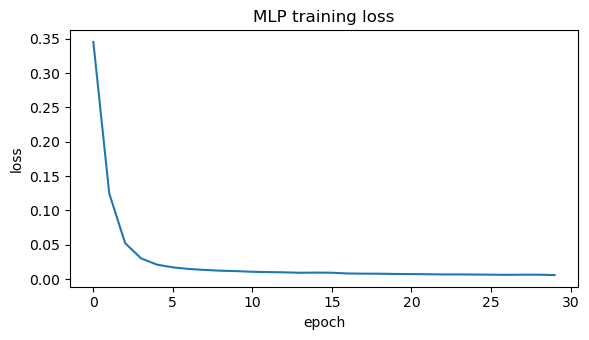

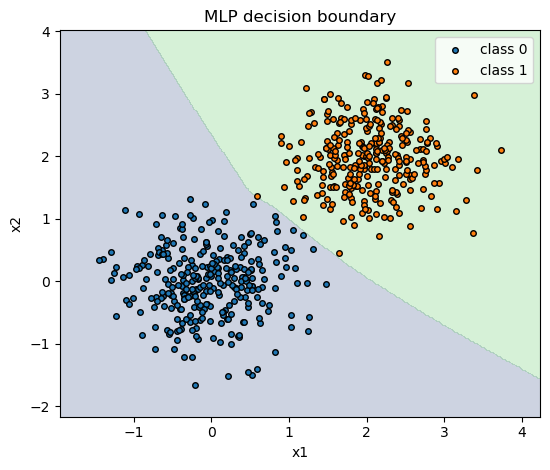

In [5]:
# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Data: two Gaussian blobs
n_per = 300
cov = 0.3 * np.eye(2)
X0 = np.random.multivariate_normal([0, 0], cov, size=n_per)
X1 = np.random.multivariate_normal([2, 2], cov, size=n_per)
X = np.vstack([X0, X1]).astype(np.float32)
y = np.concatenate([np.zeros(n_per), np.ones(n_per)]).astype(np.int64)

# Convert to tensors and build loader
X_t = torch.from_numpy(X)
y_t = torch.from_numpy(y)
ds = TensorDataset(X_t, y_t)
dl = DataLoader(ds, batch_size=64, shuffle=True)

# Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

print("Using device: ", device)
model = MLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

# Train
loss_hist = []
for epoch in range(30):
    model.train()
    running = 0.0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()
        running += loss.item() * len(xb)
    loss_hist.append(running / len(ds))

# Evaluate accuracy
model.eval()
with torch.no_grad():
    logits = model(X_t.to(device))
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()
acc = (y_pred == y).mean()
print(f"Training accuracy: {acc:.4f}")

# Plot loss
plt.figure(figsize=(6,3.5))
plt.plot(loss_hist)
plt.title("MLP training loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.tight_layout(); plt.show()

# Decision boundary visualization
pad = 0.5
x_min, x_max = X[:,0].min() - pad, X[:,0].max() + pad
y_min, y_max = X[:,1].min() - pad, X[:,1].max() + pad
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

with torch.no_grad():
    logits_grid = model(torch.from_numpy(grid).to(device))
    pred_grid = torch.argmax(logits_grid, dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(5.6,4.8))
plt.contourf(xx, yy, pred_grid, alpha=0.25, levels=[-0.5,0.5,1.5])
plt.scatter(X0[:,0], X0[:,1], s=16, label="class 0", edgecolor="k")
plt.scatter(X1[:,0], X1[:,1], s=16, label="class 1", edgecolor="k")
plt.title("MLP decision boundary")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
plt.tight_layout(); plt.show()


## 3. Regression with MSE

In **regression**, the goal is to predict a **continuous target** $ y \in \mathbb{R} $ from input features $ x \in \mathbb{R}^n $. A neural model (or any differentiable function) $ f_\theta(x) $ is trained by minimizing the **Mean Squared Error (MSE)**:

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \big(f_\theta(x_i) - y_i\big)^2
$$

Here:
- $ f_\theta(x) $ → predicted value  
- $ y_i $ → ground truth  
- The gradient w.r.t. parameters $ \theta $ points toward reducing the prediction error.


### Intuition
The model learns to fit a regression line (or surface) through the data that minimizes squared deviations between predictions and actual values.  
Unlike classification, the output layer here is **linear** (no softmax or sigmoid).


### RL Connection
- In **value function approximation**, the critic predicts expected returns $ V_\theta(s) $.  
- The training signal comes from **bootstrapped targets**, e.g.:
  $$
  \mathcal{L}(\theta) = \mathbb{E}\big[(r_t + \gamma V_\theta(s_{t+1}) - V_\theta(s_t))^2\big]
  $$
- This is the same **MSE objective**, but the targets are dynamic (changing as learning progresses).

> Understanding regression with MSE provides the mathematical and coding foundation for **critic updates**, **Q-learning**, and **actor-critic** algorithms in deep reinforcement learning.

Using device:  mps
MSE: 0.0905   R^2: 0.9838


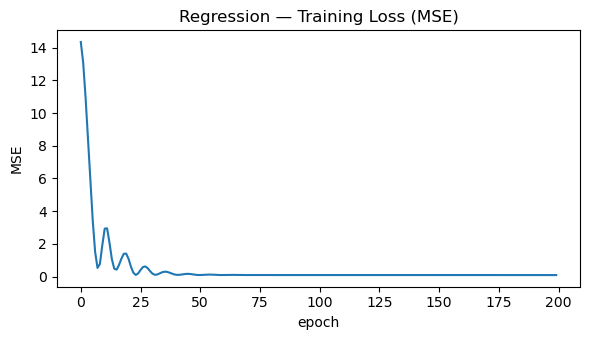

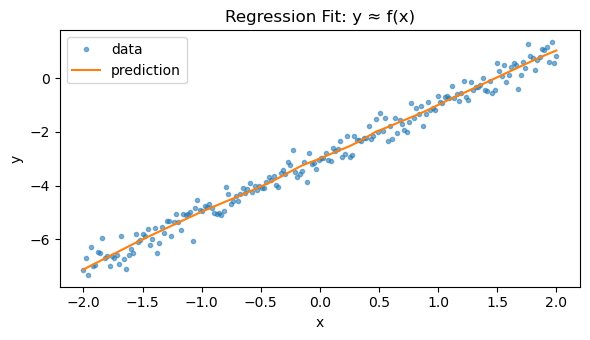

In [7]:
# Synthetic data: y = 2x - 3 + noise
xs = np.linspace(-2, 2, 200, dtype=np.float32).reshape(-1, 1)
ys = (2 * xs - 3 + 0.3 * np.random.randn(*xs.shape)).astype(np.float32)

Xt = torch.from_numpy(xs).to(device)
Yt = torch.from_numpy(ys).to(device)

# Model: small MLP (can fit linear smoothly)
reg = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)
print("Using device: ", device)

opt = torch.optim.SGD(reg.parameters(), lr=1e-2, momentum=0.9)
mse = nn.MSELoss()

# Train
losses = []
for epoch in range(200):
    opt.zero_grad()
    pred = reg(Xt)
    loss = mse(pred, Yt)
    loss.backward()
    opt.step()
    losses.append(loss.item())

# Metrics: MSE & R^2 on full dataset
with torch.no_grad():
    yp = reg(Xt).cpu().numpy()
mse_val = float(np.mean((ys - yp)**2))
ss_res = float(np.sum((ys - yp)**2))
ss_tot = float(np.sum((ys - ys.mean())**2))
r2 = 1.0 - ss_res / ss_tot
print(f"MSE: {mse_val:.4f}   R^2: {r2:.4f}")

# Plot training loss
plt.figure(figsize=(6, 3.5))
plt.plot(losses)
plt.title("Regression — Training Loss (MSE)")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.tight_layout(); plt.show()

# Visualize fit
plt.figure(figsize=(6, 3.5))
plt.plot(xs, ys, ".", alpha=0.55, label="data")
plt.plot(xs, yp, "-", label="prediction")
plt.title("Regression Fit: y ≈ f(x)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

## Key Takeaways

- **Autograd** — PyTorch automatically computes gradients via backpropagation.
- **nn.Module & Optimizers** — Simplify model definition and parameter updates.
- **Foundation for RL** — Core of policy, value, and world model training in deep RL.

**Next**: `05_gymnasium_basics.ipynb` → explore RL environments and agent–environment loops.